In [24]:
#from LSV import *
import pyfreeling as freeling
import sys
import re
import pandas as pd
import speech_recognition as sr
from moviepy.editor import *
from os import listdir
from IPython.display import Image as Imagepy
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 
from difflib import SequenceMatcher as SM
import difflib

In [2]:
freeling.util_init_locale("default");
lang = "es" ; ipath = "/usr"
lpath = ipath + "/share/freeling/" + lang + "/"
tk=freeling.tokenizer(lpath+"tokenizer.dat");
sp=freeling.splitter(lpath+"splitter.dat");




In [3]:

def my_maco_options(lang,lpath) :

    # create options holder 
    opt = freeling.maco_options(lang);

    # Provide files for morphological submodules. Note that it is not 
    # necessary to set file for modules that will not be used.
    opt.UserMapFile = "";
    opt.LocutionsFile = lpath + "locucions.dat"; 
    opt.AffixFile = lpath + "afixos.dat";
    opt.ProbabilityFile = lpath + "probabilitats.dat"; 
    opt.DictionaryFile = lpath + "dicc.src";
    opt.NPdataFile = lpath + "np.dat"; 
    opt.PunctuationFile = lpath + "../common/punct.dat"; 
    return opt;



morfo=freeling.maco(my_maco_options(lang,lpath));
morfo.set_active_options (False,  # UserMap 
                          True,  # NumbersDetection,  
                          True,  # PunctuationDetection,   
                          False,  # DatesDetection,    
                          True,  # DictionarySearch,  
                          True,  # AffixAnalysis,  
                          False, # CompoundAnalysis, 
                          True,  # RetokContractions,
                          False,  # MultiwordsDetection,  
                          True,  # NERecognition,     
                          False, # QuantitiesDetection,  
                          True); # ProbabilityAssignment                 
tagger = freeling.hmm_tagger(lpath+"tagger.dat",True,2)
# create sense annotator
sen = freeling.senses(lpath+"senses.dat");
# create sense disambiguator
wsd = freeling.ukb(lpath+"ukb.dat");
sdb = freeling.semanticDB(lpath+"semdb.dat");
# create dependency parser
parser = freeling.dep_treeler(lpath+"dep_treeler/dependences.dat");

In [4]:
def txt_to_dict(file_path):
    final_list = ''
    with open(file_path) as lines:
        for lineItem in lines:
            attribute = lineItem.split(':')[0]
            try:
                value = lineItem.split(':')[1]
            except:
                value = lineItem
                #print ('--->Falta por clasificar')
            final_list = final_list + (attribute+':'+value+',')
    final_list = final_list.rstrip(',').replace('\n','').replace(' ','') 
    lines_dict = dict((k,v) for k, v in (e.split(':') for e in final_list.split(',')))
    return lines_dict


# In[4]:


def get_re_value(line, re_value, group_number = 0): 
    value = re.search(re_value,line)
    if not value:
        return None 
    value = value.group(group_number)
    return value


# In[5]:


def clean_input(token, list_):
    for iterator in list_:    
        val = get_re_value(token, iterator)
        if val:
            return True
    return False


# In[43]:


def is_something(syns,categories,sdb):
    is_top = False
    is_label = False
    for syn in syns:
        is_top = False
        is_label = False
        while not is_label:  
            si = sdb.get_sense_info(syn)
            for label in categories:
                is_label = (si.sumo == label)
                #print (label)
                if is_label:
                    is_top = True
                    break
                else:
                    if len(si.parents) > 0 :
                        syn = si.parents[0]
                        continue
                    else:
                        is_top = True
                        is_label = 'NoValid'
                        break
        if is_label != 'NoValid':
            return (categories[label])
    return False


# In[42]:


def is_sumo_tag(syns,label,sdb):
    is_top = False
    is_label = False
    while not is_label:
        si = sdb.get_sense_info(syns)
        is_label = (si.sumo == label)
        if is_label:
            is_top = True
            break
        else:
            if len(si.parents) > 0 :
                syns = si.parents[0]
                continue
            else:
                is_top = True
                is_label = 'NoValid'
                break
    if is_label != 'NoValid':
        return (label)
    return False




def analize_gender_number(tag):
    #DAOFS0
    #gender = [3]
    #number = [4]
    gender = '' ; number = ''
    if tag[3] == 'F' or tag[2] == 'F': gender = '$F'
    if tag[3] == 'M' or tag[2] == 'M': gender = '$M'
    if tag[3] == 'N' or tag[2] == 'N': gender = ''
    if tag[4] == 'S' or tag[3] == 'S': number = ''
    if tag[4] == 'P' or tag[3] == 'P': number = '$P'
    if tag[4] == 'N' or tag[3] == 'N': number = ''
    return (gender, number)    
        
    


# In[40]:



def is_syns_tag(syns,label,sdb):
    is_top = False ; is_label = False; a = 0
    for syn in syns:
        while not is_label and not is_top:
            si = sdb.get_sense_info(syn)
            is_label = (si.sumo == label)
            if is_label:
                is_top = True
                return True
            else:
                if len(si.parents) > 0 and a<=4:
                    a = a+1
                    syn = si.parents[0]
                else:
                    is_top = True
        is_top = False ; is_label = False
    return False
    



# In[12]:


def get_word_info(word):
    if len(word.get_senses())>0:
        try:
            syns = (word.get_senses()[0][0],word.get_senses()[1][0])
        except:
            syns = (word.get_senses()[0][0])
    else:
        syns = '' 
    return word.get_tag(),word.get_lemma(),word.get_form(),syns


# In[13]:


def get_expresions(tag,expresions, expresions_final):
    expre = ''
    if tag[0:3] in expresions_final:
        expre = (expresions_final[tag[0:3]])
        expre = ''
    else:
        if tag[0:3] in expresions:
            expre =(expresions[tag[0:3]])
    return expre


# In[14]:


def spell(name): 
    spell_name = ''
    for letter in name:
        spell_name = spell_name +str.upper(letter)+ '-'
    return spell_name.rstrip('-')


# In[16]:


def get_number(tag):
    if tag[0] == 'P' or tag[0] == 'D':
        if tag[4] == 'P' : return '$P'
    if tag[3] == 'P' : return '$P'
    return ''


# In[17]:



       



In [5]:
def AnalizeSentense(S,O,V, s):
    Stag,Slemma,Sform,Ssyn =  get_word_info(S)
    Otag,Olemma,Oform,Osyn =  get_word_info(O)
    Vtag,Vlemma,Vform,Vsyn =  get_word_info(V)
    Slist = [S]
    Spos = s.get_word_iterator(S)
    for w,it in zip(s, range(len(s))):         
        wtag,wlemma,wform,wsyn =  get_word_info(w)
        if (wlemma != Slemma):
            if wlemma == Slemma:
                if (s[it+1].get_lemma() == 'y' or s[it+1].get_form() == ','):
                    Slist.append(s[it+2])
                    continue
    return {'O':O,'S':Slist,'V':V}
        

    

In [6]:
def get_SVO(s):
    for w in s:
        #print (w.get_lemma(),w.get_tag())
        pass
        #print (w.get_lemma(),end = ' ')
    for pred in s.get_predicates():
        A0 = False ;A1 = False;A2 = False; PRED = False; trip = False
        for arg in pred :
            if arg.get_role()== "A1" : A1 = s[arg.get_position()]
            elif arg.get_role()== "A0" : A0 = s[arg.get_position()]
            elif arg.get_role()== "A2" : A2 = s[arg.get_position()]
        if (A0 and A1):
            PRED = s[pred.get_position()]
            trip = AnalizeSentense(A0,A1,PRED,s)
        if (A1 and A2): 
            PRED = s[pred.get_position()]
            trip = AnalizeSentense(A1,A2,PRED,s)          
    if not trip: return False
    else: return trip

In [7]:
def get_word_info(word):
    if len(word.get_senses())>0:
        try:
            syns = (word.get_senses()[0][0],word.get_senses()[1][0])
        except:
            syns = (word.get_senses()[0][0])
    else:
        syns = '' 
    return word.get_tag(),word.get_lemma(),word.get_form(),syns

In [8]:
def analizeVerb(w, flag, neg = '' ):
    number = ''
    tag = w.get_tag()
    if (tag[0:2] == 'VA' or tag[0:2] == 'VS'):
        time = get_time(tag)
        lemma = w.get_lemma()
        if flag == False and lemma == 'haber':
            lemma = w.get_lemma()
            if tag[6] == '0': lemma = neg + ' ' + lemma
            else:
                if tag[4:6] == '1S':
                    lemma =  'YO '+neg+' '+lemma
                if tag[4:6] == '2S':
                    lemma =  'TU '+neg+' '+lemma
                elif tag[4:6] == '3S':
                    lemma =  'EL ' +neg+' '+lemma    
                elif tag[4:6] == '1P':
                    lemma =  'NOSOTROS '+neg+' '+lemma 
                elif tag[4:6] == '2P':
                    lemma =  'USTEDES '+neg+' '+lemma 
                elif tag[4:6] == '3P':
                    lemma =  'ELLOS '+neg+' '+lemma
        elif flag == False and lemma == 'ser':
            lemma = ''
            #if tag[6] == '0': lemma = neg
            #else: 
            if tag[4:6] == '1S':
                lemma =  'YO ' + neg
            if tag[4:6] == '2S':
                lemma =  'TU ' + neg
            elif tag[4:6] == '3S':
                lemma =  neg     
            elif tag[4:6] == '1P':
                lemma =  'NOSOTROS ' + neg
            elif tag[4:6] == '2P':
                lemma =  'USTEDES ' + neg
            elif tag[4:6] == '3P':
                lemma =  'ELLOS ' + neg
        elif flag and lemma == 'ser': 
            lemma = ''
        if w.get_lemma() == 'ser':
            if time == '$Pasado':
                lemma = lemma + ' $SerPasado'
                time = ''
            elif time == '$Futuro':
                lemma = lemma + ' $SerFuturo'
                time = ''
            else:
                lemma = lemma +' $SerPresente'
                time = ''       
    elif tag[0:2] == 'VM' and not flag :
        lemma = w.get_lemma()
        #if tag[6] == '0':
        #    return (get_time(tag),'',neg+' '+lemma)
        #if lemma == 'estar':
        #    lemma = ''
        if tag[4:6] == '1S':
            lemma =  'YO '+neg+' '+lemma
        elif tag[4:6] == '2S':
            lemma =  'TU '+neg+' '+lemma 
        elif tag[4:6] == '3S':
            lemma = neg+' '+lemma    
        elif tag[4:6] == '1P':
            lemma =  'NOSOTROS '+neg+' '+lemma
        elif tag[4:6] == '2P':
            lemma =  'USTEDES '+neg+' '+lemma
        elif tag[4:6] == '3P':
            lemma =  'ELLOS '+neg+' '+lemma 
        time = get_time(tag)
    else:
        
        lemma = neg + ' '+ w.get_lemma()
        time = get_time(tag) 
     
    return time, number, lemma

In [9]:
def analizeVerb_(w):
    number = ''
    tag = w.get_tag()
    if (tag[0:2] == 'VA' or tag[0:2] == 'VS'):
        time = get_time(tag)       
    elif tag[0:2] == 'VM':
        time = get_time(tag)
    return time, number

In [10]:
def extract_lemma_and_sense(w) :
    lem = w.get_lemma()
    sens=""
    if len(w.get_senses())>0 :
        sens = w.get_senses()[0][0]
    return lem, sens


In [11]:

def formatOut(lemma_out):
    out = ''
    dic_tags = {'$P': 'MUCHO','$F':'SENA_FEMENINO','$M':'SENA_MASCULINO','$Pasado':'SENA_PASADO','$Futuro':'SENA_FUTURO','$SerPresente':'SENA_SER_PRESENTE','$SerPasado':'SENA_SER_PASADO','$SerFuturo':'SENA_SER_FUTURO'}
    for lemma in lemma_out.split():
        if lemma in dic_tags:
            print (dic_tags[lemma],end = ' ')
            out = out +' '+ dic_tags[lemma]
        else:
            print (str.upper(lemma).replace('Á','A').replace('É','E').replace('Í','I').replace('Ó','O').replace('Ú','U').replace('Ü','U'), end = ' ')
            out = out +' '+ str.upper(lemma).replace('Á','A').replace('É','E').replace('Í','I').replace('Ó','O').replace('Ú','U').replace('Ü','U').replace('.','\n')
    return out    
    

In [12]:
def get_time(tag):    
    if tag[3] == 'P' or tag[2] == 'G' : return ''
    if tag[3] == 'F' : return '$Futuro'
    if tag[3] == 'S' or tag[3] == 'I'  : return '$Pasado'
    return ''
    

In [29]:
def ProcessSentences(ls, sdb):    
    exceptions_=['^P[0-3A-Z]{4}D','Fc','^DA','Fd','Flt','Fla',
                 'Fe','Frc','Fra','Fx', 'Faa','Fat','Fia','Fit']    
    female_words = ['mujer','dama','madre','mamá','hombre','caballero','padre','papá']
    s_aux = freeling.sentence();
    expre = '' ; gender = ''; number = '' ; time = '' 
    out = ''
    for s in ls :
        for w in s:
            if (clean_input(list_=exceptions_,token=w.get_tag())):
                    continue
            s_aux.push_back(w)   
        leng = len(s_aux)
    out = getSentence(s_aux, exceptions_,female_words, False,sdb)
    out = formatOut(out)      
    return out


In [31]:
def getSentence(s,exceptions_,female_words, flag,sdb):
    out = ''; neg = False; human = False
    for word,itera in zip(s,range(len (s))):
        if ((word.get_tag()[0:2] == 'SD' and  word.get_lemma() in ['a']) or (word.get_tag()[0:2]== 'P0' and word.get_lemma() != 'se') or (word.get_lemma()== 'nos')):
            continue        
        tag,lemma,form,syn = get_word_info(word)
        time = ''; number = ''; gender = ''
        print (flag, tag, lemma)
        if tag[0] == 'N':
            if flag: 
                #Si ya hay un sujeto debe analizar el objeto, solo busco genero si es persona o deletreo si es nombre propio
                if lemma.find('_') != -1:
                    lemma = lemma.replace('_',' ')  
                if (tag[0:2] == 'NC'):
                    if not is_syns_tag(syn,'Human=',sdb):
                        #number = get_number(tag)
                        gender = ''    
                    else:
                        (gender, number)= analize_gender_number(tag) 
                        number = ''
                        if (lemma.replace(' ','') in female_words): gender = ''
                else:
                    #Se deletran los nombres propios.
                    lemma = spell(lemma)  
                    gender = ''; number = ''
                if neg:
                    lemma = neg_ +' '+ lemma
                    neg = False 
                    
                flag = False
            else:
                flag = True
                if lemma.find('_') != -1:
                    lemma = lemma.replace('_',' ')  
                if (tag[0:2] == 'NC'):
                    if not is_syns_tag(syn,'Human=',sdb):
                        number = get_number(tag)
                        gender = ''    
                    else:
                        (gender, number)= analize_gender_number(tag) 
                        if (lemma.replace(' ','') in female_words): gender = ''
                else:
                    #Se deletran los nombres propios.
                    lemma = spell(lemma)  
                    gender = ''; number = ''
                if neg:
                    lemma = neg_ +' '+ lemma
                    neg = False
        
        elif flag == False and ((tag[0:2] == 'PD' or tag[0:2] == 'PI' or tag[0:2] == 'PP' or tag[0:2] == 'DD')) :
            if not is_syns_tag(syn,'Human=',sdb):
                        #number = get_number(tag)
                        gender = ''    
            else:
                (gender, number)= analize_gender_number(tag) 
            try:
                if (s[itera+1].get_tag()[0] == 'N'):
                    tag_,lemma_,form_,syn_ = get_word_info(s[itera+1])
                    gender = ''
                    number = ''
                    if is_syns_tag(syn_,'Human=',sdb):
                        human = True           
            except: 
                number = ''; gender = ''
            if neg:
                lemma = neg_ +' '+ lemma
                neg = False
            if human == True:
                flag = False
            else:
                flag = True
        else:
                number = '' ; gender = ''
        #Si se tiene un nombre antes 
        if tag[0] == 'V':
            #print (tag, lemma)
            if neg:
                time, number,lemma = analizeVerb(word,flag,neg_)
                neg = False
            else:
                time, number,lemma = analizeVerb(word,flag)
            
        if tag[0:2] == 'RN':
            neg = True
            neg_ = lemma
            if flag:
                neg = False
            elif neg and not flag:
                lemma = ''
            
            else: print(lemma)
        out = out + ' '+ lemma+' '+gender+' '+number+' '+time+' '
    return out

In [32]:
text = ''
f = open ('out.txt','w')
with open('input.txt') as lineas:    
    for text in lineas:
        if text == '':
            break
        lw = tk.tokenize(text.replace('\n',''))
        ls = sp.split(lw)
        ls = morfo.analyze(ls)
        ls = wsd.analyze(ls)
        ls = tagger.analyze(ls)
        ls = sen.analyze(ls);
        out = ProcessSentences(ls,sdb)
        f.write(out)
        f.write('\n')
f.close()

Input:martes, jueves

Output:

False NCMN000 martes
True NCMN000 jueves
MARTES JUEVES 

In [16]:
#Modulo de pruebas con entrada por teclado
texto = ''
while texto != '$C':
    texto = input("Texto a traducir:")
    if texto == '$C': continue
    lw = tk.tokenize(texto.replace('\n',''))
    # split list of words in sentences, return list of sentences
    ls = sp.split(lw)
    # perform morphosyntactic analysis and disambiguationn
    ls = morfo.analyze(ls)
    ls = tagger.analyze(ls)
    ls = sen.analyze(ls);
    ls = wsd.analyze(ls);
    #ls = parser.analyze(ls);  
    # do whatever is needed with processed sentences 
    #print ('Input:'+texto+'\n')
    print ('Output:'+'\n')
    #out = ProcessSentences(ls,sdb, exceptions, categories, expresions, expresions_final)
    out = ProcessSentences(ls,sdb)
    print ('\n')

Texto a traducir:el amor es una magina
Output:

False NCMS000 amor
True VSIP3S0 ser
True DI0FS0 uno
True VMIP3S0 magina
AMOR SENA_SER_PRESENTE UNO MAGINA 

Texto a traducir:$C


In [17]:
La palabra reservada struct indica que se está definiendo una estructura. El identificador ejemplo es el nombre de la estructura. Las variables declaradas dentro de las llaves de la definición de estructura son los miembros
de la estructura. Los miembros de la misma estructura deben tener nombres únicos mientras que dos estructuras diferentes pueden tener miembros con el mismo nombre.

SyntaxError: invalid syntax (<ipython-input-17-f94448c0dc66>, line 1)

In [ ]:
##Modulo de pruebhas con reconocimiento de audio.
r = sr.Recognizer()
with sr.Microphone() as source:
    print("Di algo:")
    audio = r.listen(source)
#Speech recognition using Google Speech Recognition
try:
    text = r.recognize_google(audio,language = "es-ES")
    print("Dijiste: " + text)
except sr.UnknownValueError:
    print("Google Speech Recognition could not understand audio")
    text = ''
except sr.RequestError as e:
    print("Could not request results from Google Speech Recognition service; {0}".format(e))
    text = ''

categories = txt_to_dict('categories.txt') ; expresions = txt_to_dict('expresions.txt') ; expresions_final = txt_to_dict('expresions_final.txt')
prev_expre = ''

lw = tk.tokenize(text.replace('\n',''))
# split list of words in sentences, return list of sentences
ls = sp.split(lw)
# perform morphosyntactic analysis and disambiguation
ls = morfo.analyze(ls)
ls = tagger.analyze(ls)
ls = sen.analyze(ls);
ls = wsd.analyze(ls);
#ls = parser.analyze(ls);  
# do whatever is needed with processed sentences 
print ('Input:'+text+'\n')
print ('Output:'+'\n')
#out = ProcessSentences(ls,sdb, exceptions, categories, expresions, expresions_final)
out = ProcessSentences(ls,sdb, categories, expresions, expresions_final)
print ('\n')

Texto a traducir:el amor es una magia una simple fantasia
Input:el amor es una magia una simple fantasia

Output:

False NCMS000 amor
True VSIP3S0 ser
True DI0FS0 uno
True NCFS000 magia
False DI0FS0 uno
False AQ0CS00 simple
False NCFS000 fantasia
AMOR SENA_SER_PRESENTE UNO MAGIA UNO SIMPLE FANTASIA 


[MoviePy] Building file out.gif with imageio


 99%|█████████▉| 90/91 [00:02<00:00, 30.20it/s]


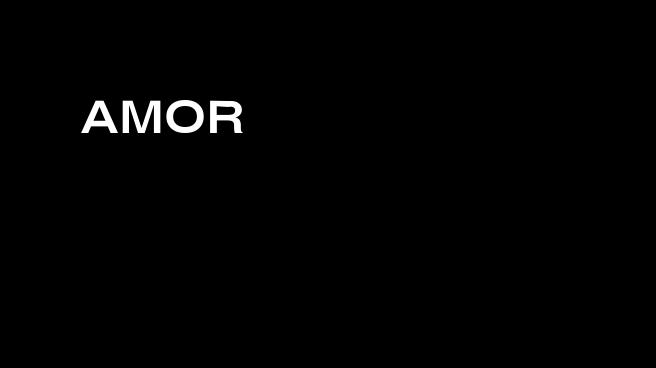

Texto a traducir:$C


In [26]:
#Modulo de pruebas con entrada por teclado
categories = txt_to_dict('categories.txt') ; expresions = txt_to_dict('expresions.txt') ; expresions_final = txt_to_dict('expresions_final.txt')
texto = ''; prev_expre = ''; order = ['tag','lemma','word','expresion','gender','number','time']
while texto != '$C':
    texto = input("Texto a traducir:")
    if texto == '$C': continue
    lw = tk.tokenize(texto.replace('\n',''))
    # split list of words in sentences, return list of sentences
    ls = sp.split(lw)
    # perform morphosyntactic analysis and disambiguation
    ls = morfo.analyze(ls)
    ls = tagger.analyze(ls)
    ls = sen.analyze(ls);
    ls = wsd.analyze(ls);
    #ls = parser.analyze(ls);  
    # do whatever is needed with processed sentences 
    print ('Input:'+texto+'\n')
    print ('Output:'+'\n')
    #out = ProcessSentences(ls,sdb, exceptions, categories, expresions, expresions_final)
    out = ProcessSentences(ls,sdb, categories, expresions, expresions_final)
    print ('\n')    
    input_path =  os.getcwd()
    clip = []
    filenames = listdir(input_path+'/Images/')
    for lemmas in out.split():
        spell_flag = False
        if lemmas.find('-') != -1:
            letters = lemmas.replace('-','')
            letters = (letters)+'.gif'
            spell_flag = True
        lemmas_ = (lemmas)
        lemmas = (lemmas)+'.gif'
        if lemmas in filenames:
            if spell_flag == True:
                for l in letters:
                    clip.append((VideoFileClip(input_path+'/Images/'+l)))
            else:
                clip.append((VideoFileClip(input_path+'/Images/'+lemmas)).set_duration(2))
        else:
            for mi_iterador_diff in filenames:
                my_ratio = (SM(None, lemmas, mi_iterador_diff).ratio())
                if my_ratio > 0.90:
                    print (mi_iterador_diff, '->',lemmas, my_ratio) 
            if spell_flag == True:
                letters = letters.replace('.gif','')
                for l in letters:
                    img = Image.open(input_path+'/Images/default.jpg')
                    draw = ImageDraw.Draw(img)
                    font = ImageFont.truetype("SSF.ttf", 45)
                    draw.text((260,170),l,(255,255,255),font=font)
                    img.save('sample_out.jpg')
                    clip.append((VideoFileClip(input_path+'/sample_out.jpg')).set_duration(0.5))
            else: 
                img = Image.open(input_path+'/Images/default.jpg')
                draw = ImageDraw.Draw(img)
                font = ImageFont.truetype("SSF.ttf", 45)
                draw.text((80,100),lemmas_,(255,255,255),font=font)
                img.save('sample_out.jpg')
                clip.append((VideoFileClip(input_path+'/sample_out.jpg')).set_duration(1))            
    if len(clip)>0:
        composition = concatenate_videoclips(clip)
        composition.write_gif('out.gif', fps=10)
        x = Imagepy(filename="out.gif", width=700) 
        display(x)
    else:
        print ('No disponible')


In [ ]:
input_path =  os.getcwd()
##Modulo de pruebas con reconocimiento de audio.
r = sr.Recognizer()
with sr.Microphone() as source:
    print("Di algo:")
    audio = r.listen(source)
#Speech recognition using Google Speech Recognition
try:
    text = r.recognize_google(audio,language = "es-ES")
    print("Dijiste: " + text)
except sr.UnknownValueError:
    print("Google Speech Recognition could not understand audio")
    text = ''
except sr.RequestError as e:
    print("Could not request results from Google Speech Recognition service; {0}".format(e))
    text = ''

categories = txt_to_dict('categories.txt') ; expresions = txt_to_dict('expresions.txt') ; expresions_final = txt_to_dict('expresions_final.txt')
prev_expre = ''

lw = tk.tokenize(text.replace('\n',''))
# split list of words in sentences, return list of sentences
ls = sp.split(lw)
# perform morphosyntactic analysis and disambiguation
ls = morfo.analyze(ls)
ls = tagger.analyze(ls)
ls = sen.analyze(ls);
ls = wsd.analyze(ls);
#ls = parser.analyze(ls);  
# do whatever is needed with processed sentences 
print ('Input:'+text+'\n')
print ('Output:'+'\n')
#out = ProcessSentences(ls,sdb, exceptions, categories, expresions, expresions_final)
out = ProcessSentences(ls,sdb, categories, expresions, expresions_final)
input_path =  os.getcwd()
clip = []
filenames = listdir(input_path+'/Images/')
for lemmas in out.split():
    spell_flag = False
    if lemmas.find('-') != -1:
        letters = lemmas.replace('-','')
        letters = (letters)+'.gif'
        spell_flag = True
    lemmas_ = (lemmas)
    lemmas = (lemmas)+'.gif'
    if lemmas in filenames:
        if spell_flag == True:
            for l in letters:
                clip.append((VideoFileClip(input_path+'/Images/'+l)))
        else:
            clip.append((VideoFileClip(input_path+'/Images/'+lemmas)).set_duration(2))
    else:

        if spell_flag == True:
            letters = letters.replace('.gif','')
            for l in letters:
                img = Image.open(input_path+'/Images/default.jpg')
                draw = ImageDraw.Draw(img)
                font = ImageFont.truetype("SSF.ttf", 45)
                draw.text((260,170),l,(255,255,255),font=font)
                img.save('sample_out.jpg')
                clip.append((VideoFileClip(input_path+'/sample_out.jpg')).set_duration(0.5))
        else: 
            img = Image.open(input_path+'/Images/default.jpg')
            draw = ImageDraw.Draw(img)
            font = ImageFont.truetype("SSF.ttf", 45)
            draw.text((100,100),lemmas_,(255,255,255),font=font)
            img.save('sample_out.jpg')
            clip.append((VideoFileClip(input_path+'/sample_out.jpg')).set_duration(1))            
if len(clip)>0:
    composition = concatenate_videoclips(clip)
    composition.write_gif('out.gif', fps=10)
    x = Imagepy(filename="out.gif", width=700) 
    display(x)
else:
    print ('No disponible')
